In [1]:
import numpy as np
import seaborn as sn
from imblearn.over_sampling import SMOTE 
import keras
from keras.utils import np_utils
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras import losses
from keras.datasets import mnist
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import class_weight
from sklearn.metrics import recall_score, confusion_matrix, multilabel_confusion_matrix, precision_score, precision_recall_curve, average_precision_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from pandas import DataFrame
import xlsxwriter
import time


#Extra features that are available: Sex, Gestational Age 

#22 1s Atypicals defined as having an attention problem t-score >= 65 in BASC2 6year
#115 0s

Using TensorFlow backend.


In [2]:
Training_Data = pd.ExcelFile("Scaled_Gilmore_Data_CT_SA_1_2.xlsx") #Training Data already pre-scaled to the IBIS Data set
Label_Data = pd.ExcelFile("Labels.xlsx") #Labels
data = Training_Data.parse(Training_Data.sheet_names[0])
label_data = Label_Data.parse(Label_Data.sheet_names[0])
data_features = data.loc[:, data.columns]
data_features = data_features.drop(['ROI','MATCH','INDEX','MATCH2','INDEX2', 'ATP', 'HYP', 'ATP Middle', 'HYP Label', 'ATP Label'], axis=1)
data_features = data_features.dropna()
data_features = data_features.drop(['HYP Middle'], axis=1)
labels = label_data.loc[:, label_data.columns]
labels = labels.drop(['ROI','ATP Middle', 'HYP Label', 'ATP Label'], axis=1)
labels = labels.dropna()
print(data_features.shape)
print(labels.shape)

seed = 7 #Set to the same seed as my gridSearchCV until I can run more gridSearchCVs with random seeds and average them. This is after I try the different class weight gridSearches.
print("SEED:",seed)

(125, 298)
(125, 1)
SEED: 7


In [3]:
data_features = data_features.to_numpy()
labels = labels.to_numpy()

skf = StratifiedKFold(n_splits=8)
skf.get_n_splits(data_features, labels)
print(skf)

training_folds_X = []
testing_folds_X = []
training_folds_Y = []
testing_folds_Y = []

for train_index, test_index in skf.split(data_features, labels):
  
    X_train, X_test = data_features[train_index], data_features[test_index]
    Y_train, Y_test = labels[train_index], labels[test_index]
   
    sm = SMOTE(sampling_strategy = 'minority', random_state = seed, k_neighbors=2) 
    X_train_smoted, Y_train_smoted = sm.fit_sample(X_train, Y_train) #Only smote the training set.
    
    training_folds_X.append(X_train_smoted)
    testing_folds_X.append(X_test)
    training_folds_Y.append(Y_train_smoted)
    testing_folds_Y.append(Y_test)


StratifiedKFold(n_splits=8, random_state=None, shuffle=False)


In [4]:
def create_summary_matrix(p0, p1, p2, p3, p4, p5, p6, p7, t0, t1, t2, t3, t4, t5, t6, t7):
    predictions = []
    true = []
    
    for i in range(0,p0.size):
        if p0[i] == 0:
            predictions.append(0)
        if p0[i] == 1:
            predictions.append(1)
        if t0[i] == 0:
            true.append(0)
        if t0[i] == 1:
            true.append(1)
    for i in range(0,p1.size):
        if p1[i] == 0:
            predictions.append(0)
        if p1[i] == 1:
            predictions.append(1)
        if t1[i] == 0:
            true.append(0)
        if t1[i] == 1:
            true.append(1)
    for i in range(0,p2.size):
        if p2[i] == 0:
            predictions.append(0)
        if p2[i] == 1:
            predictions.append(1)
        if t2[i] == 0:
            true.append(0)
        if t2[i] == 1:
            true.append(1)
    for i in range(0,p3.size):
        if p3[i] == 0:
            predictions.append(0)
        if p3[i] == 1:
            predictions.append(1)
        if t3[i] == 0:
            true.append(0)
        if t3[i] == 1:
            true.append(1)
    for i in range(0,p4.size):
        if p4[i] == 0:
            predictions.append(0)
        if p4[i] == 1:
            predictions.append(1)
        if t4[i] == 0:
            true.append(0)
        if t4[i] == 1:
            true.append(1)
    for i in range(0,p5.size):
        if p5[i] == 0:
            predictions.append(0)
        if p5[i] == 1:
            predictions.append(1)
        if t5[i] == 0:
            true.append(0)
        if t5[i] == 1:
            true.append(1)
    for i in range(0,p6.size):
        if p6[i] == 0:
            predictions.append(0)
        if p6[i] == 1:
            predictions.append(1)
        if t6[i] == 0:
            true.append(0)
        if t6[i] == 1:
            true.append(1)
    for i in range(0,p7.size):
        if p7[i] == 0:
            predictions.append(0)
        if p7[i] == 1:
            predictions.append(1)
        if t7[i] == 0:
            true.append(0)
        if t7[i] == 1:
            true.append(1)
    
    
    prec_score = precision_score(true, predictions, average=None)
    print('Positive Predictive Value tp/(tp+fp): ',prec_score[1])
    
    rec_score = recall_score(true, predictions, average=None)
    print('Recall Value tp/(tp+fn): ',rec_score[1])
    
    cf_matrix = confusion_matrix(true, predictions)
    print(cf_matrix)
    sn.heatmap(cf_matrix, annot=True)
    

In [5]:
#Best: 0.497768 using {'batch_size': 35, 'dropout': 0.3, 'epochs': 100, 'layer1_size': 100, 'layer2_size': 20}
def run_model(n):
    input_size = 298
    hidden_size1 = 100
    hidden_size2 = 20
    output_size = 1
    
    input_data = Input(shape=(input_size,))
    hidden_d_1 = Dense(hidden_size1, activation='relu')(input_data)
    hidden_d_1_d = Dropout(0.30,  noise_shape=None, seed=None)(hidden_d_1)
    hidden_d_2 = Dense(hidden_size2, activation='relu')(hidden_d_1_d)
    predicted = Dense(output_size, activation='sigmoid')(hidden_d_2)

    predictor = Model(input_data, predicted)
    predictor.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['acc'] )

    class_weights={0:1, 1:4} 
    
    p = predictor.fit(training_folds_X[n], training_folds_Y[n],
    epochs=100,
    batch_size=35,
    shuffle=True,
    validation_data=(testing_folds_X[n], testing_folds_Y[n]), class_weight=class_weights)

    #Plotting loss
    plt.plot(p.history['loss'])
    plt.plot(p.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.axis([0, 30, 0.0, 1.10])
    plt.show()

    #Plotting Accuracy
    plt.plot(p.history['acc'])
    plt.plot(p.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['acc', 'val_acc'], loc='upper left')
    plt.axis([0, 30, 0.0, 1.05])
    plt.show()
    
    
    predictions = predictor.predict(testing_folds_X[n])
    predicted_classes = (predictions > 0.5).astype(int)

    #Heatmap for the confusion matrix
    cf_matrix = confusion_matrix(testing_folds_Y[n], predicted_classes)
    print(cf_matrix)
    sn.heatmap(cf_matrix, annot=True)
    average_precision = average_precision_score(predicted_classes, testing_folds_Y[n])

    
    prec_score = precision_score(testing_folds_Y[n], predicted_classes, average=None)
    print('PPV: ',prec_score[1])
    
    rec_score = recall_score(testing_folds_Y[n], predicted_classes, average=None)
    print('Recall: ',rec_score[1])

    
    return predicted_classes, testing_folds_Y[n]
    


Train on 194 samples, validate on 16 samples
Epoch 1/100
194/194 [==============================] - 2s 11ms/step - loss: 1.4469 - acc: 0.5000 - val_loss: 1.4520 - val_acc: 0.1250
Epoch 2/100
194/194 [==============================] - 0s 195us/step - loss: 1.2671 - acc: 0.5000 - val_loss: 1.5725 - val_acc: 0.1250
Epoch 3/100
194/194 [==============================] - 0s 161us/step - loss: 1.2228 - acc: 0.5000 - val_loss: 1.2745 - val_acc: 0.1250
Epoch 4/100
194/194 [==============================] - 0s 161us/step - loss: 1.1904 - acc: 0.5000 - val_loss: 1.2353 - val_acc: 0.1250
Epoch 5/100
194/194 [==============================] - ETA: 0s - loss: 1.1756 - acc: 0.485 - 0s 161us/step - loss: 1.1493 - acc: 0.5000 - val_loss: 1.2079 - val_acc: 0.1250
Epoch 6/100
194/194 [==============================] - 0s 347us/step - loss: 1.0985 - acc: 0.5000 - val_loss: 1.2825 - val_acc: 0.1250
Epoch 7/100
194/194 [==============================] - 0s 167us/step - loss: 1.0782 - acc: 0.5155 - val_loss

Epoch 61/100
194/194 [==============================] - 0s 123us/step - loss: 0.0114 - acc: 1.0000 - val_loss: 0.6267 - val_acc: 0.8125
Epoch 62/100
194/194 [==============================] - 0s 165us/step - loss: 0.0076 - acc: 1.0000 - val_loss: 0.6234 - val_acc: 0.8125
Epoch 63/100
194/194 [==============================] - 0s 118us/step - loss: 0.0076 - acc: 1.0000 - val_loss: 0.6631 - val_acc: 0.8125
Epoch 64/100
194/194 [==============================] - 0s 154us/step - loss: 0.0081 - acc: 1.0000 - val_loss: 0.6634 - val_acc: 0.8125
Epoch 65/100
194/194 [==============================] - 0s 144us/step - loss: 0.0062 - acc: 1.0000 - val_loss: 0.6428 - val_acc: 0.8125
Epoch 66/100
194/194 [==============================] - 0s 123us/step - loss: 0.0105 - acc: 1.0000 - val_loss: 0.6804 - val_acc: 0.8125
Epoch 67/100
194/194 [==============================] - 0s 108us/step - loss: 0.0056 - acc: 1.0000 - val_loss: 0.6847 - val_acc: 0.8125
Epoch 68/100
194/194 [==========================

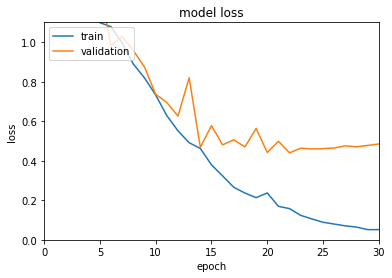

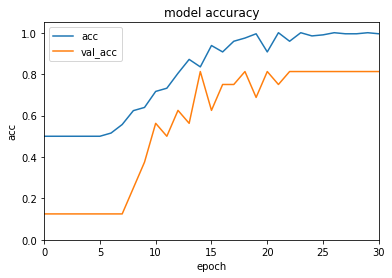

[[13  1]
 [ 2  0]]
PPV:  0.0
Recall:  0.0


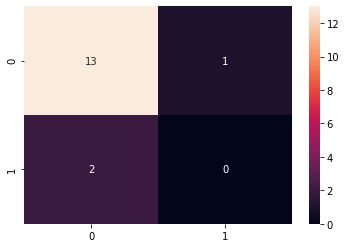

In [6]:
p0, t0 = run_model(0)

Train on 194 samples, validate on 16 samples
Epoch 1/100
194/194 [==============================] - 3s 16ms/step - loss: 1.4684 - acc: 0.4845 - val_loss: 1.4237 - val_acc: 0.1250
Epoch 2/100
194/194 [==============================] - 0s 206us/step - loss: 1.2732 - acc: 0.5000 - val_loss: 1.7410 - val_acc: 0.1250
Epoch 3/100
194/194 [==============================] - 0s 139us/step - loss: 1.2451 - acc: 0.5000 - val_loss: 1.4327 - val_acc: 0.1250
Epoch 4/100
194/194 [==============================] - 0s 200us/step - loss: 1.1957 - acc: 0.5000 - val_loss: 1.2696 - val_acc: 0.1250
Epoch 5/100
194/194 [==============================] - 0s 175us/step - loss: 1.1332 - acc: 0.5000 - val_loss: 1.3305 - val_acc: 0.1250
Epoch 6/100
194/194 [==============================] - ETA: 0s - loss: 1.2676 - acc: 0.400 - 0s 139us/step - loss: 1.1237 - acc: 0.5103 - val_loss: 1.2527 - val_acc: 0.1250
Epoch 7/100
194/194 [==============================] - 0s 242us/step - loss: 1.0775 - acc: 0.5206 - val_loss

194/194 [==============================] - 0s 154us/step - loss: 0.0177 - acc: 1.0000 - val_loss: 0.5663 - val_acc: 0.8750
Epoch 61/100
194/194 [==============================] - 0s 129us/step - loss: 0.0093 - acc: 1.0000 - val_loss: 0.5429 - val_acc: 0.8750
Epoch 62/100
194/194 [==============================] - 0s 267us/step - loss: 0.0147 - acc: 1.0000 - val_loss: 0.5515 - val_acc: 0.8750
Epoch 63/100
194/194 [==============================] - 0s 134us/step - loss: 0.0115 - acc: 1.0000 - val_loss: 0.5580 - val_acc: 0.8750
Epoch 64/100
194/194 [==============================] - 0s 185us/step - loss: 0.0085 - acc: 1.0000 - val_loss: 0.5634 - val_acc: 0.8750
Epoch 65/100
194/194 [==============================] - 0s 262us/step - loss: 0.0117 - acc: 1.0000 - val_loss: 0.5863 - val_acc: 0.8750
Epoch 66/100
194/194 [==============================] - 0s 324us/step - loss: 0.0105 - acc: 1.0000 - val_loss: 0.5370 - val_acc: 0.8750
Epoch 67/100
194/194 [==============================] - 0s 37

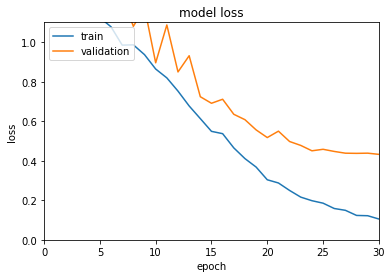

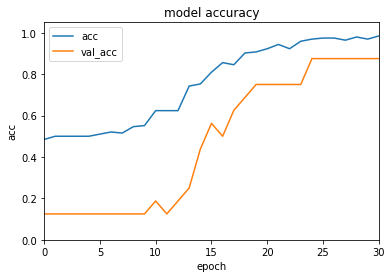

[[14  0]
 [ 2  0]]


C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_ranking.py:681: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


PPV:  0.0
Recall:  0.0


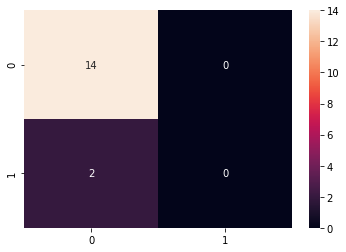

In [7]:
p1, t1 = run_model(1)

Train on 194 samples, validate on 16 samples
Epoch 1/100
194/194 [==============================] - 4s 22ms/step - loss: 1.4982 - acc: 0.5258 - val_loss: 1.4329 - val_acc: 0.1250
Epoch 2/100
194/194 [==============================] - 0s 200us/step - loss: 1.2761 - acc: 0.5000 - val_loss: 1.8722 - val_acc: 0.1250
Epoch 3/100
194/194 [==============================] - 0s 149us/step - loss: 1.2847 - acc: 0.5000 - val_loss: 1.6076 - val_acc: 0.1250
Epoch 4/100
194/194 [==============================] - 0s 139us/step - loss: 1.2269 - acc: 0.5000 - val_loss: 1.3946 - val_acc: 0.1250
Epoch 5/100
194/194 [==============================] - 0s 144us/step - loss: 1.1827 - acc: 0.5000 - val_loss: 1.2777 - val_acc: 0.1250
Epoch 6/100
194/194 [==============================] - 0s 175us/step - loss: 1.1393 - acc: 0.5103 - val_loss: 1.3804 - val_acc: 0.1250
Epoch 7/100
194/194 [==============================] - 0s 149us/step - loss: 1.1087 - acc: 0.5258 - val_loss: 1.2747 - val_acc: 0.1250
Epoch 8/100

Epoch 61/100
194/194 [==============================] - 0s 123us/step - loss: 0.0154 - acc: 1.0000 - val_loss: 0.4872 - val_acc: 0.9375
Epoch 62/100
194/194 [==============================] - 0s 123us/step - loss: 0.0156 - acc: 1.0000 - val_loss: 0.4956 - val_acc: 0.9375
Epoch 63/100
194/194 [==============================] - 0s 149us/step - loss: 0.0181 - acc: 1.0000 - val_loss: 0.4875 - val_acc: 0.9375
Epoch 64/100
194/194 [==============================] - 0s 257us/step - loss: 0.0147 - acc: 1.0000 - val_loss: 0.4831 - val_acc: 0.9375
Epoch 65/100
194/194 [==============================] - 0s 175us/step - loss: 0.0153 - acc: 1.0000 - val_loss: 0.4790 - val_acc: 0.9375
Epoch 66/100
194/194 [==============================] - 0s 118us/step - loss: 0.0101 - acc: 1.0000 - val_loss: 0.4858 - val_acc: 0.9375
Epoch 67/100
194/194 [==============================] - 0s 134us/step - loss: 0.0132 - acc: 1.0000 - val_loss: 0.4980 - val_acc: 0.9375
Epoch 68/100
194/194 [==========================

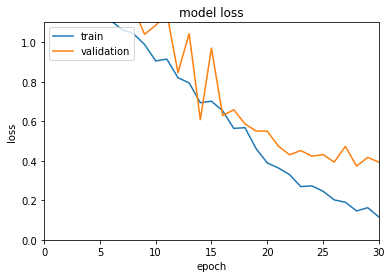

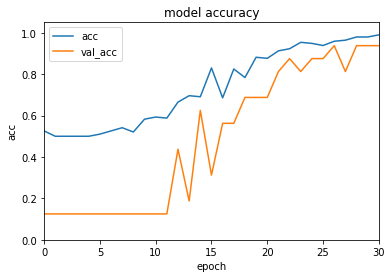

[[14  0]
 [ 1  1]]
PPV:  1.0
Recall:  0.5


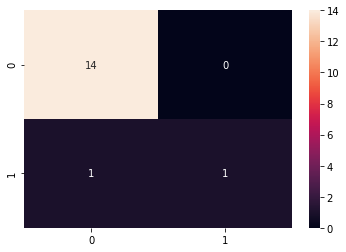

In [8]:
p2, t2 = run_model(2)

Train on 194 samples, validate on 16 samples
Epoch 1/100
194/194 [==============================] - 4s 23ms/step - loss: 1.5329 - acc: 0.4639 - val_loss: 1.1951 - val_acc: 0.1250
Epoch 2/100
194/194 [==============================] - 0s 350us/step - loss: 1.2532 - acc: 0.5000 - val_loss: 1.6224 - val_acc: 0.1250
Epoch 3/100
194/194 [==============================] - 0s 494us/step - loss: 1.2487 - acc: 0.5000 - val_loss: 1.5641 - val_acc: 0.1250
Epoch 4/100
194/194 [==============================] - 0s 278us/step - loss: 1.2187 - acc: 0.5052 - val_loss: 1.2391 - val_acc: 0.1250
Epoch 5/100
194/194 [==============================] - 0s 329us/step - loss: 1.1652 - acc: 0.5052 - val_loss: 1.1948 - val_acc: 0.1250
Epoch 6/100
194/194 [==============================] - 0s 288us/step - loss: 1.1415 - acc: 0.5000 - val_loss: 1.4347 - val_acc: 0.1250
Epoch 7/100
194/194 [==============================] - 0s 298us/step - loss: 1.0901 - acc: 0.5052 - val_loss: 1.2036 - val_acc: 0.1250
Epoch 8/100

Epoch 61/100
194/194 [==============================] - 0s 113us/step - loss: 0.0080 - acc: 1.0000 - val_loss: 0.9800 - val_acc: 0.8750
Epoch 62/100
194/194 [==============================] - 0s 123us/step - loss: 0.0064 - acc: 1.0000 - val_loss: 0.9731 - val_acc: 0.8750
Epoch 63/100
194/194 [==============================] - 0s 123us/step - loss: 0.0052 - acc: 1.0000 - val_loss: 1.0074 - val_acc: 0.8750
Epoch 64/100
194/194 [==============================] - 0s 129us/step - loss: 0.0056 - acc: 1.0000 - val_loss: 1.0144 - val_acc: 0.8750
Epoch 65/100
194/194 [==============================] - 0s 108us/step - loss: 0.0065 - acc: 1.0000 - val_loss: 1.0064 - val_acc: 0.8750
Epoch 66/100
194/194 [==============================] - 0s 159us/step - loss: 0.0069 - acc: 1.0000 - val_loss: 1.0156 - val_acc: 0.8750
Epoch 67/100
194/194 [==============================] - 0s 144us/step - loss: 0.0053 - acc: 1.0000 - val_loss: 1.0278 - val_acc: 0.8750
Epoch 68/100
194/194 [==========================

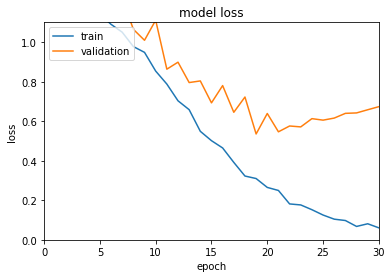

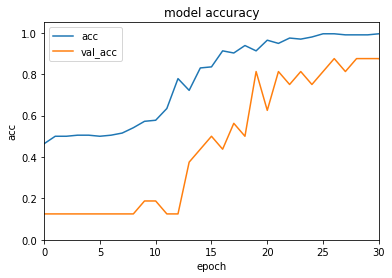

[[14  0]
 [ 2  0]]
PPV:  0.0
Recall:  0.0


C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_ranking.py:681: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


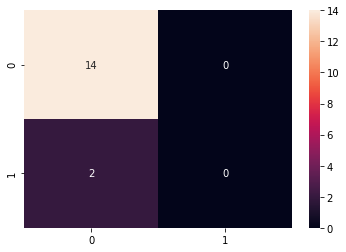

In [9]:
p3, t3 = run_model(3)

Train on 194 samples, validate on 16 samples
Epoch 1/100
194/194 [==============================] - 4s 20ms/step - loss: 1.5735 - acc: 0.4691 - val_loss: 1.2512 - val_acc: 0.1250
Epoch 2/100
194/194 [==============================] - 0s 396us/step - loss: 1.2626 - acc: 0.5000 - val_loss: 1.6408 - val_acc: 0.1250
Epoch 3/100
194/194 [==============================] - 0s 355us/step - loss: 1.2501 - acc: 0.5000 - val_loss: 1.4949 - val_acc: 0.1250
Epoch 4/100
194/194 [==============================] - 0s 314us/step - loss: 1.2016 - acc: 0.5000 - val_loss: 1.3671 - val_acc: 0.1250
Epoch 5/100
194/194 [==============================] - 0s 329us/step - loss: 1.1907 - acc: 0.5000 - val_loss: 1.2054 - val_acc: 0.1250
Epoch 6/100
194/194 [==============================] - 0s 329us/step - loss: 1.1492 - acc: 0.5000 - val_loss: 1.2890 - val_acc: 0.1250
Epoch 7/100
194/194 [==============================] - 0s 329us/step - loss: 1.1017 - acc: 0.5052 - val_loss: 1.3290 - val_acc: 0.1250
Epoch 8/100

Epoch 61/100
194/194 [==============================] - 0s 252us/step - loss: 0.0153 - acc: 1.0000 - val_loss: 0.7659 - val_acc: 0.8125
Epoch 62/100
194/194 [==============================] - 0s 298us/step - loss: 0.0059 - acc: 1.0000 - val_loss: 0.7891 - val_acc: 0.8750
Epoch 63/100
194/194 [==============================] - 0s 355us/step - loss: 0.0078 - acc: 1.0000 - val_loss: 0.8160 - val_acc: 0.8750
Epoch 64/100
194/194 [==============================] - 0s 257us/step - loss: 0.0079 - acc: 1.0000 - val_loss: 0.8737 - val_acc: 0.8750
Epoch 65/100
194/194 [==============================] - 0s 283us/step - loss: 0.0091 - acc: 1.0000 - val_loss: 0.8281 - val_acc: 0.8750
Epoch 66/100
194/194 [==============================] - 0s 236us/step - loss: 0.0083 - acc: 1.0000 - val_loss: 0.7355 - val_acc: 0.7500
Epoch 67/100
194/194 [==============================] - 0s 247us/step - loss: 0.0081 - acc: 1.0000 - val_loss: 0.7859 - val_acc: 0.8125
Epoch 68/100
194/194 [==========================

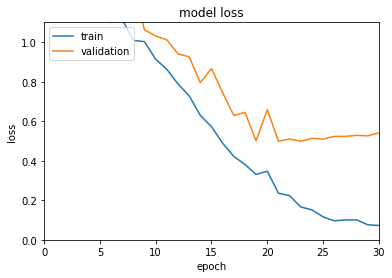

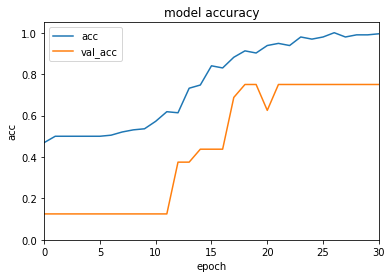

[[13  1]
 [ 2  0]]
PPV:  0.0
Recall:  0.0


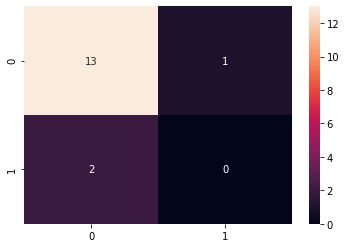

In [10]:
p4, t4 = run_model(4)

Train on 194 samples, validate on 15 samples
Epoch 1/100
194/194 [==============================] - 3s 17ms/step - loss: 1.4330 - acc: 0.4948 - val_loss: 1.6850 - val_acc: 0.0667
Epoch 2/100
194/194 [==============================] - 0s 380us/step - loss: 1.2468 - acc: 0.5000 - val_loss: 1.5698 - val_acc: 0.0667
Epoch 3/100
194/194 [==============================] - 0s 293us/step - loss: 1.2573 - acc: 0.5000 - val_loss: 1.2694 - val_acc: 0.0667
Epoch 4/100
194/194 [==============================] - 0s 391us/step - loss: 1.1741 - acc: 0.5000 - val_loss: 1.4866 - val_acc: 0.0667
Epoch 5/100
194/194 [==============================] - 0s 422us/step - loss: 1.1229 - acc: 0.5000 - val_loss: 1.3588 - val_acc: 0.0667
Epoch 6/100
194/194 [==============================] - 0s 200us/step - loss: 1.0842 - acc: 0.5052 - val_loss: 1.3194 - val_acc: 0.0667
Epoch 7/100
194/194 [==============================] - 0s 396us/step - loss: 0.9965 - acc: 0.5206 - val_loss: 1.3229 - val_acc: 0.0667
Epoch 8/100

Epoch 61/100
194/194 [==============================] - 0s 458us/step - loss: 0.0065 - acc: 1.0000 - val_loss: 1.1932 - val_acc: 0.8667
Epoch 62/100
194/194 [==============================] - 0s 591us/step - loss: 0.0079 - acc: 1.0000 - val_loss: 1.1987 - val_acc: 0.8667
Epoch 63/100
194/194 [==============================] - 0s 401us/step - loss: 0.0089 - acc: 1.0000 - val_loss: 1.2050 - val_acc: 0.8667
Epoch 64/100
194/194 [==============================] - 0s 432us/step - loss: 0.0056 - acc: 1.0000 - val_loss: 1.2050 - val_acc: 0.8667
Epoch 65/100
194/194 [==============================] - 0s 360us/step - loss: 0.0054 - acc: 1.0000 - val_loss: 1.1953 - val_acc: 0.8667
Epoch 66/100
194/194 [==============================] - 0s 288us/step - loss: 0.0062 - acc: 1.0000 - val_loss: 1.2087 - val_acc: 0.8667
Epoch 67/100
194/194 [==============================] - 0s 339us/step - loss: 0.0067 - acc: 1.0000 - val_loss: 1.2308 - val_acc: 0.8667
Epoch 68/100
194/194 [==========================

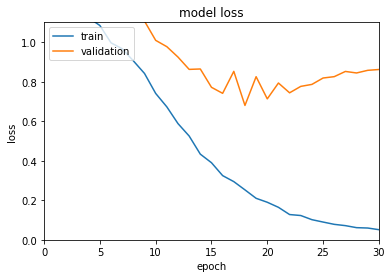

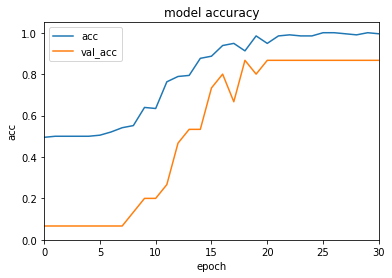

[[13  1]
 [ 1  0]]
PPV:  0.0
Recall:  0.0


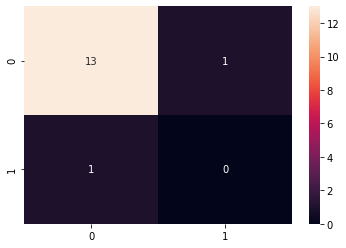

In [11]:
p5, t5 = run_model(5)

Train on 194 samples, validate on 15 samples
Epoch 1/100
194/194 [==============================] - 3s 16ms/step - loss: 1.5012 - acc: 0.4897 - val_loss: 1.4468 - val_acc: 0.0667
Epoch 2/100
194/194 [==============================] - 0s 401us/step - loss: 1.3189 - acc: 0.5000 - val_loss: 1.9052 - val_acc: 0.0667
Epoch 3/100
194/194 [==============================] - 0s 422us/step - loss: 1.2295 - acc: 0.5000 - val_loss: 1.4543 - val_acc: 0.0667
Epoch 4/100
194/194 [==============================] - 0s 257us/step - loss: 1.2119 - acc: 0.5000 - val_loss: 1.1853 - val_acc: 0.0667
Epoch 5/100
194/194 [==============================] - 0s 272us/step - loss: 1.1600 - acc: 0.5052 - val_loss: 1.4899 - val_acc: 0.0667
Epoch 6/100
194/194 [==============================] - 0s 272us/step - loss: 1.1377 - acc: 0.5000 - val_loss: 1.4001 - val_acc: 0.0667
Epoch 7/100
194/194 [==============================] - 0s 298us/step - loss: 1.0599 - acc: 0.5103 - val_loss: 1.1726 - val_acc: 0.0667
Epoch 8/100

Epoch 61/100
194/194 [==============================] - 0s 267us/step - loss: 0.0132 - acc: 1.0000 - val_loss: 0.3761 - val_acc: 0.9333
Epoch 62/100
194/194 [==============================] - 0s 236us/step - loss: 0.0151 - acc: 1.0000 - val_loss: 0.3961 - val_acc: 0.9333
Epoch 63/100
194/194 [==============================] - 0s 324us/step - loss: 0.0101 - acc: 1.0000 - val_loss: 0.3725 - val_acc: 0.9333
Epoch 64/100
194/194 [==============================] - 0s 252us/step - loss: 0.0136 - acc: 0.9948 - val_loss: 0.3811 - val_acc: 0.9333
Epoch 65/100
194/194 [==============================] - 0s 211us/step - loss: 0.0102 - acc: 1.0000 - val_loss: 0.3818 - val_acc: 0.9333
Epoch 66/100
194/194 [==============================] - 0s 324us/step - loss: 0.0101 - acc: 1.0000 - val_loss: 0.3900 - val_acc: 0.9333
Epoch 67/100
194/194 [==============================] - 0s 283us/step - loss: 0.0067 - acc: 1.0000 - val_loss: 0.3902 - val_acc: 0.9333
Epoch 68/100
194/194 [==========================

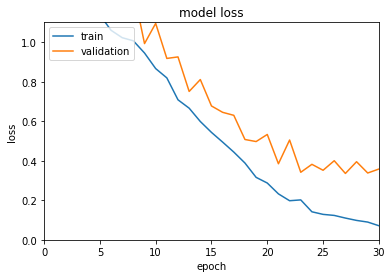

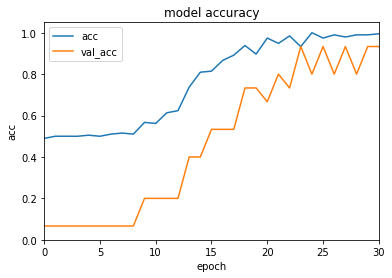

[[14  0]
 [ 1  0]]
PPV:  0.0
Recall:  0.0


C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_ranking.py:681: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


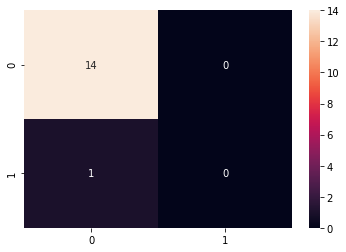

In [12]:
p6, t6 = run_model(6)

Train on 196 samples, validate on 15 samples
Epoch 1/100
196/196 [==============================] - 3s 15ms/step - loss: 1.3759 - acc: 0.5051 - val_loss: 1.6042 - val_acc: 0.1333
Epoch 2/100
196/196 [==============================] - 0s 214us/step - loss: 1.2650 - acc: 0.5000 - val_loss: 1.4642 - val_acc: 0.1333
Epoch 3/100
196/196 [==============================] - 0s 193us/step - loss: 1.2015 - acc: 0.5000 - val_loss: 1.1945 - val_acc: 0.1333
Epoch 4/100
196/196 [==============================] - 0s 173us/step - loss: 1.1587 - acc: 0.5000 - val_loss: 1.2407 - val_acc: 0.1333
Epoch 5/100
196/196 [==============================] - 0s 153us/step - loss: 1.1140 - acc: 0.5000 - val_loss: 1.2132 - val_acc: 0.1333
Epoch 6/100
196/196 [==============================] - 0s 173us/step - loss: 1.0830 - acc: 0.5000 - val_loss: 1.1573 - val_acc: 0.1333
Epoch 7/100
196/196 [==============================] - 0s 178us/step - loss: 1.0233 - acc: 0.5000 - val_loss: 1.0967 - val_acc: 0.1333
Epoch 8/100

Epoch 61/100
196/196 [==============================] - 0s 331us/step - loss: 0.0083 - acc: 1.0000 - val_loss: 0.6932 - val_acc: 0.8000
Epoch 62/100
196/196 [==============================] - 0s 300us/step - loss: 0.0071 - acc: 1.0000 - val_loss: 0.6946 - val_acc: 0.8000
Epoch 63/100
196/196 [==============================] - 0s 305us/step - loss: 0.0072 - acc: 1.0000 - val_loss: 0.7126 - val_acc: 0.8000
Epoch 64/100
196/196 [==============================] - 0s 244us/step - loss: 0.0057 - acc: 1.0000 - val_loss: 0.7273 - val_acc: 0.8000
Epoch 65/100
196/196 [==============================] - 0s 214us/step - loss: 0.0055 - acc: 1.0000 - val_loss: 0.7225 - val_acc: 0.8000
Epoch 66/100
196/196 [==============================] - 0s 305us/step - loss: 0.0057 - acc: 1.0000 - val_loss: 0.7172 - val_acc: 0.8000
Epoch 67/100
196/196 [==============================] - 0s 219us/step - loss: 0.0064 - acc: 1.0000 - val_loss: 0.7081 - val_acc: 0.8000
Epoch 68/100
196/196 [==========================

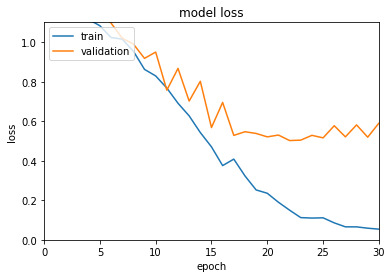

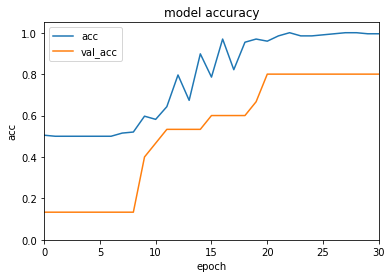

[[11  2]
 [ 1  1]]
PPV:  0.3333333333333333
Recall:  0.5


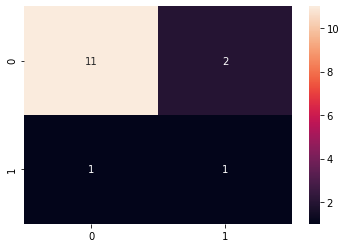

In [13]:
p7, t7 = run_model(7)

Positive Predictive Value tp/(tp+fp):  0.2857142857142857
Recall Value tp/(tp+fn):  0.14285714285714285
[[106   5]
 [ 12   2]]


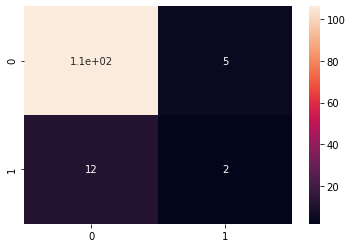

In [14]:
create_summary_matrix(p0, p1, p2, p3, p4, p5, p6, p7, t0, t1, t2, t3, t4, t5, t6, t7)